# Imports

In [14]:
import gym
import numpy as np
from itertools import count
from collections import namedtuple
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import warnings
warnings.filterwarnings('ignore')

In [15]:
SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

# Environment

In [16]:
env = gym.make('CartPole-v0')

In [17]:
env.observation_space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

# Policy and Value Natworks

In [18]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(4, 128)
        self.action_head = nn.Linear(128, 2)
        self.value_head = nn.Linear(128, 1)
        self.saved_actions = []
        self.rewards = []
    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_prob = F.softmax(self.action_head(x), dim=-1) # Policy
        state_values = self.value_head(x) # Value
        return action_prob, state_values

Function to select action stochastically

In [19]:
def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = model(state)
    m = Categorical(probs)
    action = m.sample() # Stochastic policy
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))
    return action.item()

Function to calculte actor and critic loss and perform backpropagation

In [20]:
def finish_episode():
    R = 0
    saved_actions = model.saved_actions
    policy_losses = [] # list for storing policy (actor) losses
    value_losses = [] # list for storing value (critic) losses
    returns = [] # list for storing returns

    for r in model.rewards[::-1]:
        R = r + 0.99 * R
        returns.insert(0, R)

    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps) # Standard normalization

    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item() # baseline subtraction

        policy_losses.append(-log_prob * advantage)

        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    optimizer.zero_grad()

    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    loss.backward()
    optimizer.step()

    del model.rewards[:]
    del model.saved_actions[:]

In [21]:
model = Policy()
optimizer = optim.Adam(model.parameters(), lr=3e-2)
eps = np.finfo(np.float32).eps.item() # Small value to avoid division by zero in standard normalization

# Training

In [22]:
def train():
    running_reward = 10
    for i_episode in range(500):
        state = env.reset()
        ep_reward = 0
        for t in range(1, 10000):
            action = select_action(state)
            state, reward, done, _ = env.step(action)
            model.rewards.append(reward)
            ep_reward += reward
            if done:
                break
        running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
        finish_episode()
        if i_episode % 10 == 0:
            print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}'.format(
                  i_episode, ep_reward, running_reward))
        if running_reward > env.spec.reward_threshold:
            print("Solved! Running reward is now {} and "
                  "the last episode runs to {} time steps!".format(running_reward, t))
            break

In [23]:
%%time
train()

Episode 0	Last reward: 48.00	Average reward: 11.90
Episode 10	Last reward: 36.00	Average reward: 22.74
Episode 20	Last reward: 32.00	Average reward: 27.75
Episode 30	Last reward: 77.00	Average reward: 35.50
Episode 40	Last reward: 62.00	Average reward: 52.46
Episode 50	Last reward: 41.00	Average reward: 62.07
Episode 60	Last reward: 116.00	Average reward: 68.04
Episode 70	Last reward: 200.00	Average reward: 97.17
Episode 80	Last reward: 125.00	Average reward: 116.85
Episode 90	Last reward: 91.00	Average reward: 124.77
Episode 100	Last reward: 76.00	Average reward: 110.37
Episode 110	Last reward: 200.00	Average reward: 101.75
Episode 120	Last reward: 170.00	Average reward: 126.19
Episode 130	Last reward: 115.00	Average reward: 138.02
Episode 140	Last reward: 145.00	Average reward: 154.97
Episode 150	Last reward: 200.00	Average reward: 159.11
Episode 160	Last reward: 200.00	Average reward: 171.68
Episode 170	Last reward: 182.00	Average reward: 162.96
Episode 180	Last reward: 200.00	Avera

# Evaluation

In [24]:
scores = []
for game in range(100):
  done = False
  cnt = 0
  observation = env.reset()
  while not done:
    cnt += 1
    action = select_action(observation)
    observation, reward, done, _ = env.step(action)
    if done:
        break
  scores.append(cnt)

In [25]:
score = np.array(scores)

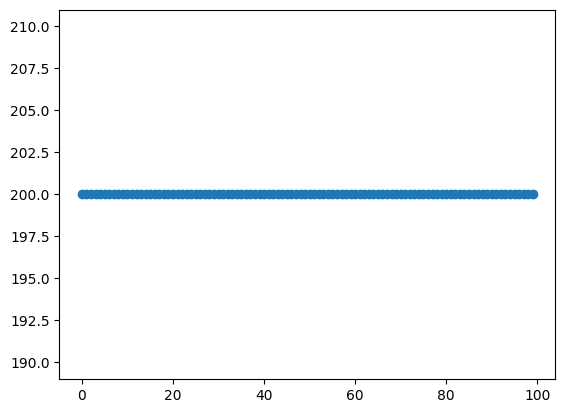

In [26]:
plt.scatter(np.arange(score.shape[0]),score)

# Further experiments

1. Hyperparameter tuning
2. Different environments
3. Explore other algorithms:


*   A2C
*   A3C
*   SAC
*   TRPO
*   PPO
*   DPG
*   DDPG
*   D4PG
*   MADDPG
*   TD3

